In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt

In [86]:
msft = yf.Ticker("MSFT")
df = msft.history(start='2021-04-01', end='2023-03-31', interval="1d")


In [87]:
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-04-01 00:00:00-04:00,232.768006,237.033511,232.358050,236.555237,30338000,0.0,0.0
2021-04-05 00:00:00-04:00,236.955442,243.983297,236.896879,243.114578,36910600,0.0,0.0
2021-04-06 00:00:00-04:00,241.689480,243.436673,240.976939,241.933502,22931900,0.0,0.0
2021-04-07 00:00:00-04:00,241.884690,244.930084,241.279519,243.924713,22719800,0.0,0.0
2021-04-08 00:00:00-04:00,246.726107,248.063345,245.974514,247.194626,23625200,0.0,0.0


In [88]:
df.index = pd.to_datetime(df.index)

In [89]:
df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

In [90]:
df = df.drop(['Open', 'High', 'Low', 'Volume'], axis=1)

In [11]:
df= df.dropna()

In [91]:
df.isna().sum()

Close    0
dtype: int64

#### Plotting the df

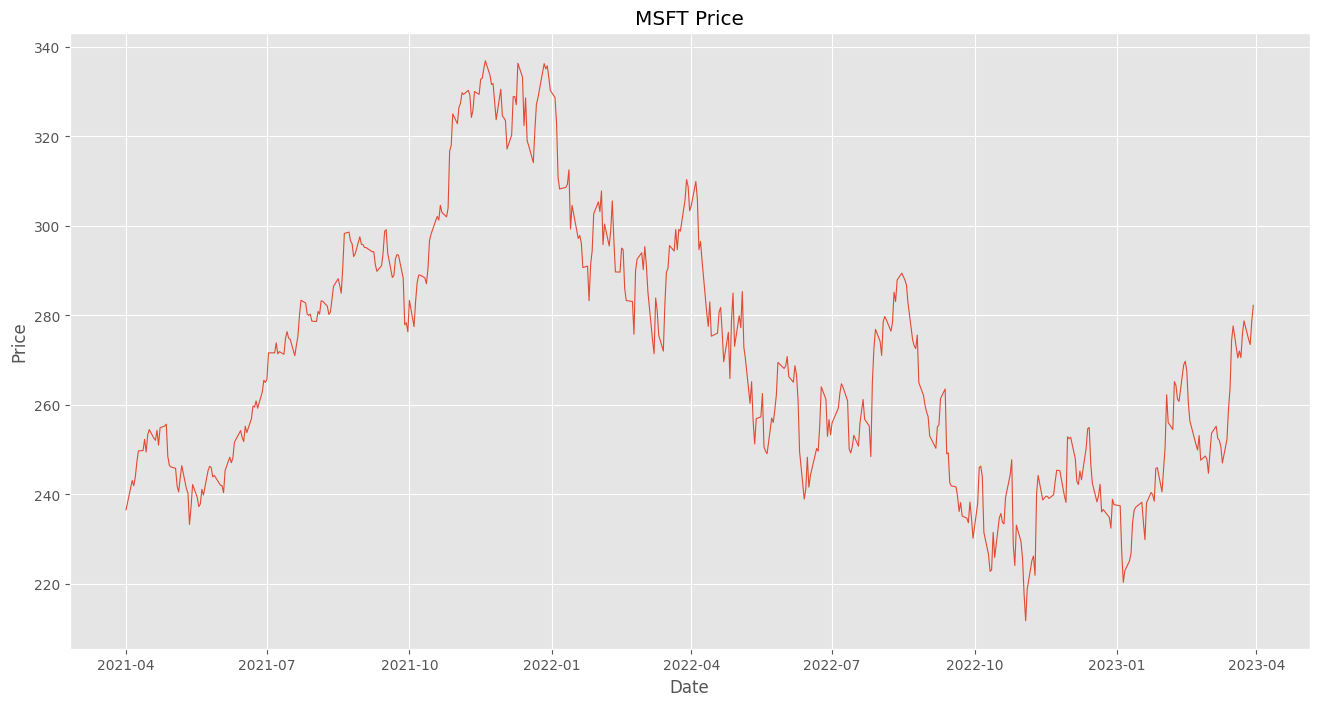

In [92]:
plt.figure(figsize=(16, 8))
plt.plot(df, linewidth=0.8)
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('MSFT Price')
plt.grid(True)
plt.style.use('ggplot')
plt.show()

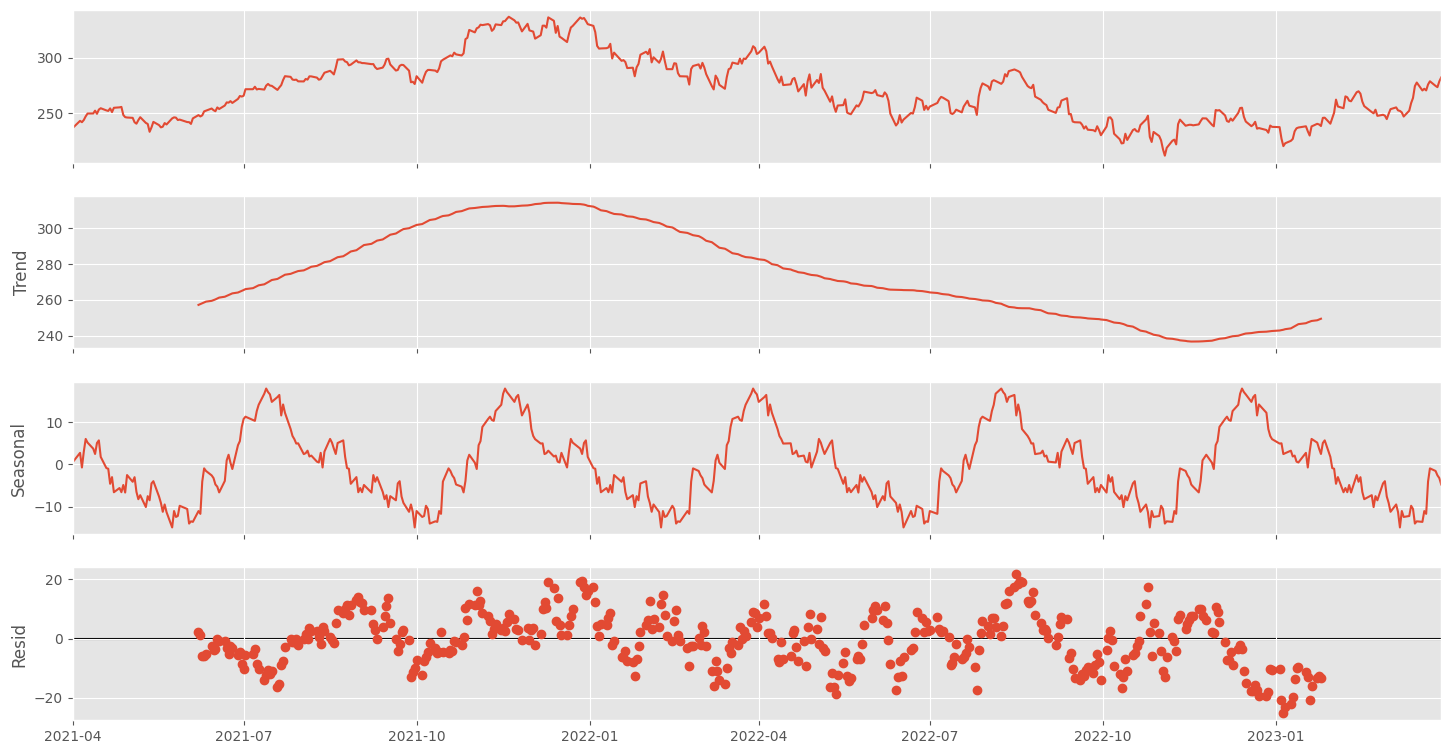

In [93]:
# Decomposition
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=90)

fig = decomposition.plot()
fig.set_size_inches(16, 8)
plt.show()

/var/folders/cz/q44l8qf10f17m9plfrjg4lz80000gn/T/ipykernel_45427/2182195207.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  x = df.index.to_period('D').astype(int)


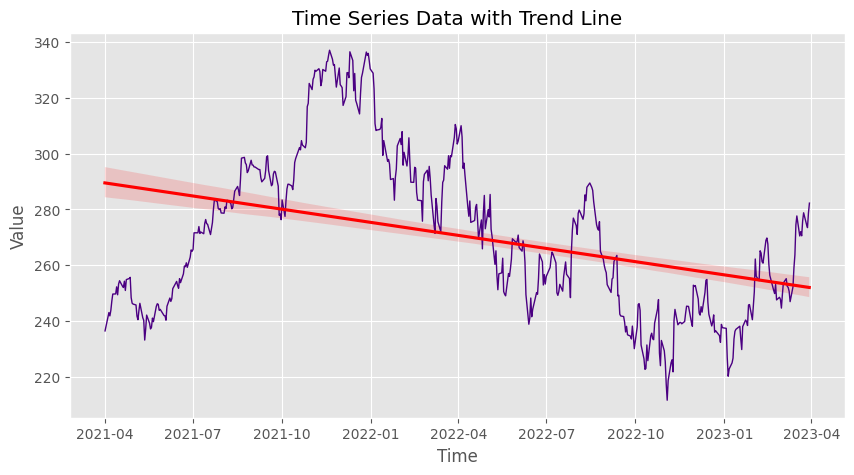

In [94]:
# Plot the time series
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='Close', color='indigo', linewidth=1)

# Convert the date index to integers
x = df.index.to_period('D').astype(int)
sns.regplot(data=df, x=x, y='Close', scatter=False, color='r')

# Add labels and title
plt.title('Time Series Data with Trend Line')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

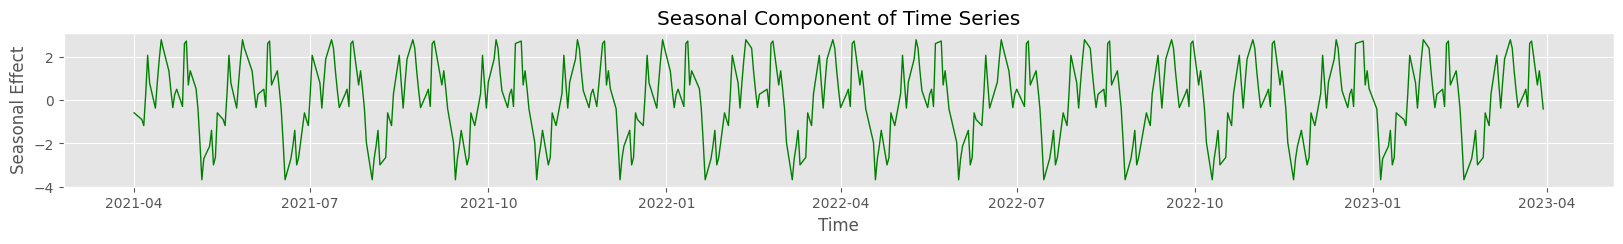

In [96]:
df = df.asfreq('B')
decomposition = sm.tsa.seasonal_decompose(df.dropna(), model='additive', period=30)
seasonal = decomposition.seasonal

plt.figure(figsize=(20, 2))
plt.plot(seasonal.index, seasonal, color='green', linewidth=1)
plt.title('Seasonal Component of Time Series')
plt.xlabel('Time')
plt.ylabel('Seasonal Effect')
plt.show()

In [18]:
# creating a year and month column for the monthly_df
df_agg = df.copy()
df_agg['Year']=df.index.year
df_agg['Month']=df.index.month
df_agg=df_agg.groupby(['Year','Month']).mean().reset_index()

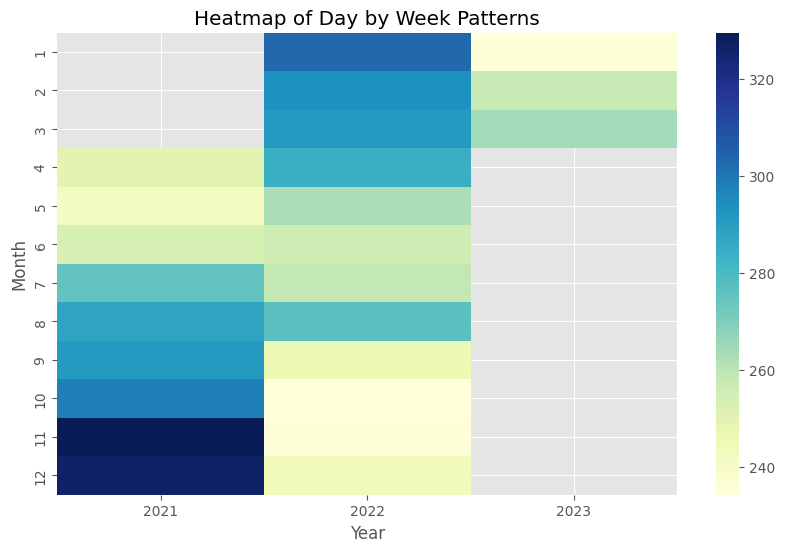

In [19]:
# Pivot your DataFrame to get days as columns and weeks as rows
pivot_table = df_agg.pivot(index='Month', columns= 'Year', values='Close')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Heatmap of Day by Week Patterns')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

In [97]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.114340
p-value: 0.238788


<Axes: xlabel='Date'>

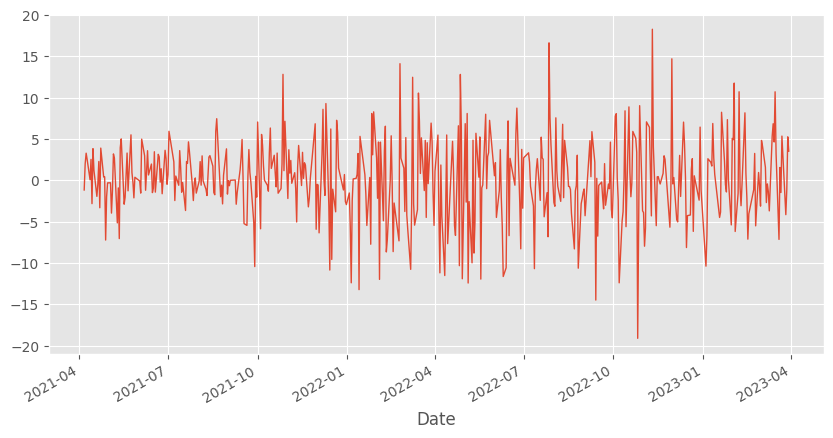

In [98]:
# create a differenced series
df['Diff'] = df['Close'].diff()
plt.figure(figsize=(10, 5))
df['Diff'].dropna().plot(linewidth=1)

In [ ]:
df

In [99]:
result = adfuller(df['Diff'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.834062
p-value: 0.000000


<Axes: xlabel='Date'>

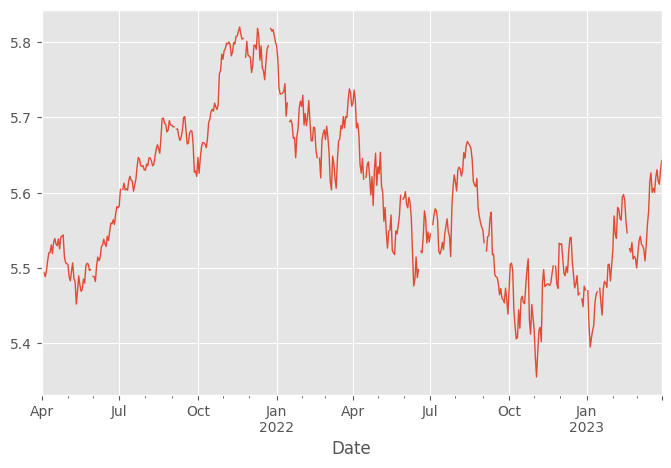

In [100]:
df['LogTransformed'] = np.log(df['Close'])
plt.figure(figsize=(8, 5))
df['LogTransformed'].plot(linewidth=1)


In [101]:
result = adfuller(df['LogTransformed'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.188068
p-value: 0.210605


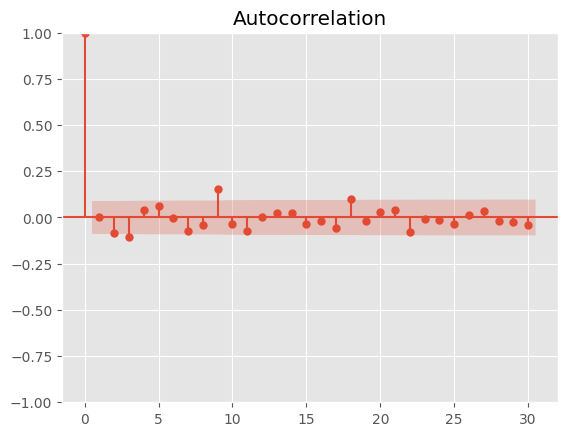

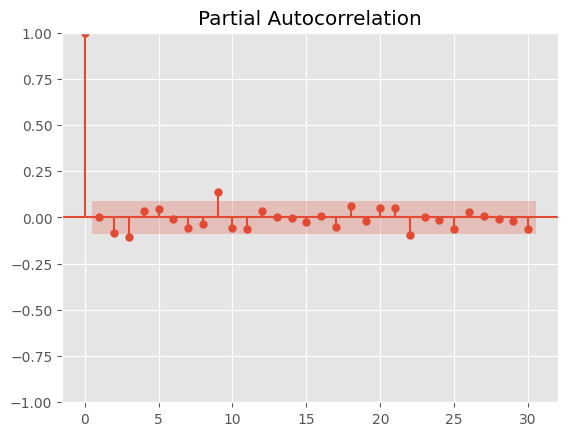

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Diff'].dropna(), lags=30)
plt.show()

plot_pacf(df['Diff'].dropna(), lags=30)
plt.show()

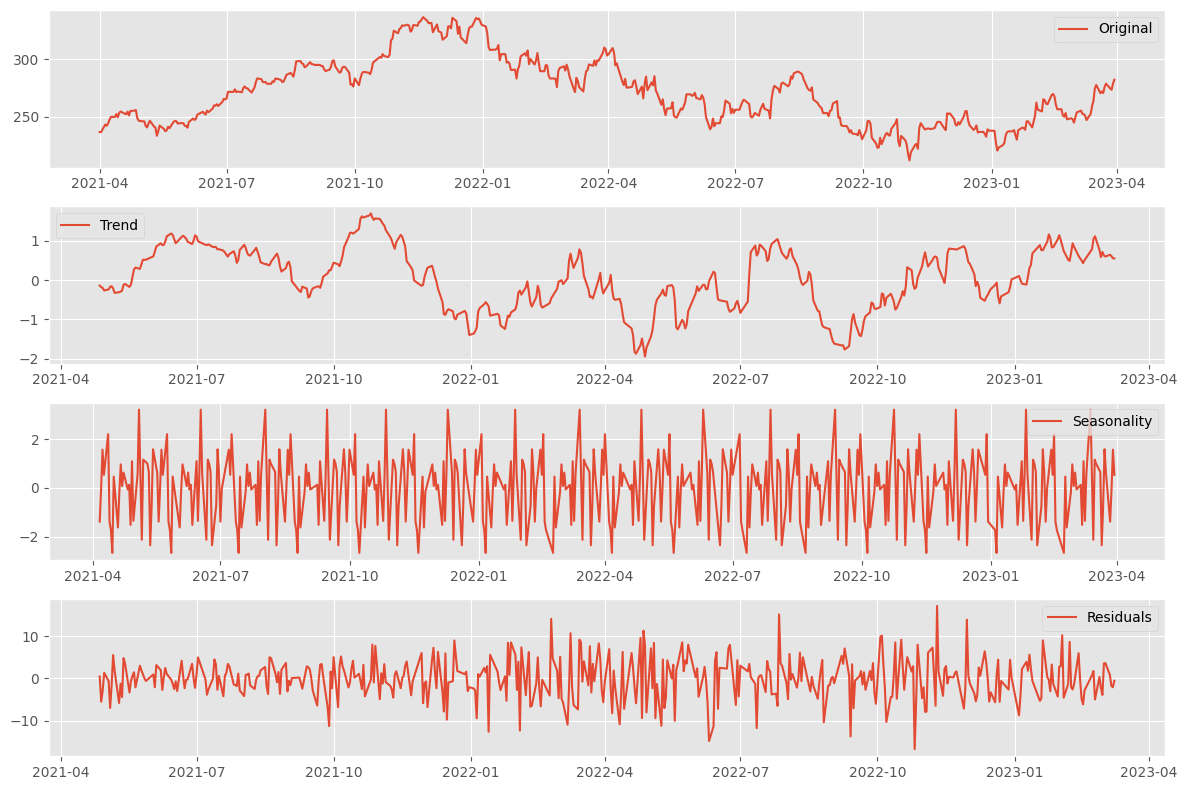

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming `ts` is your time series and `freq` is the number of observations per cycle
decomposition = seasonal_decompose(df['Diff'].dropna(), model='aditive', period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(df['Close'].ffill(), label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [121]:
df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='D'))


In [122]:
df=df.fillna(method='ffill')

/var/folders/cz/q44l8qf10f17m9plfrjg4lz80000gn/T/ipykernel_45427/1718901248.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df=df.fillna(method='ffill')


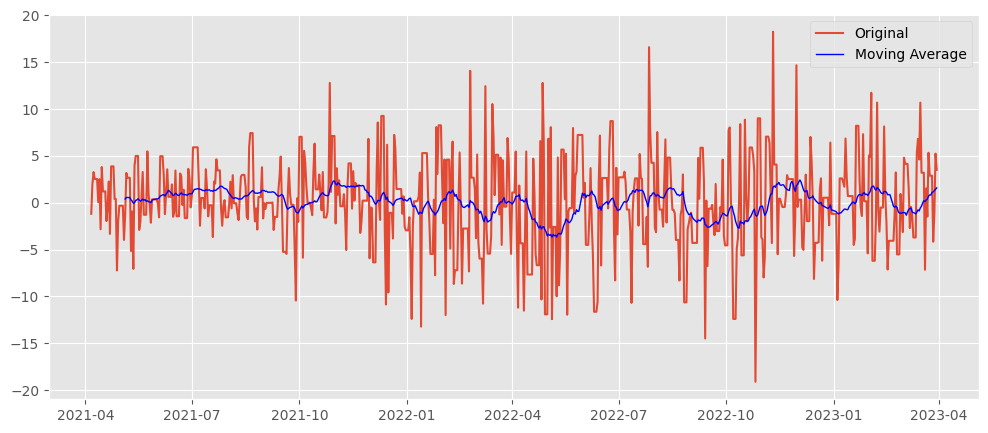

In [123]:
# Calculate the moving average using a window of 4 periods
df['Moving_Avg'] = df['Diff'].dropna().rolling(window=30).mean()

# Plot the original data and the moving average
plt.figure(figsize=(12, 5))
plt.plot(df['Diff'], label='Original')
plt.plot(df['Moving_Avg'], label='Moving Average', color='blue', linewidth=1)
plt.legend(loc='best')
plt.show()


{'smoothing_level': 0.343473018793031, 'smoothing_trend': 0.053522250924957195, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': -1.1810760498046875, 'initial_trend': 3.1722869873046875, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
                              Holt Model Results                              
Dep. Variable:                   Diff   No. Observations:                  724
Model:                           Holt   SSE                          19699.342
Optimized:                       True   AIC                           2399.770
Trend:                       Additive   BIC                           2418.109
Seasonal:                        None   AICC                          2399.887
Seasonal Periods:                None   Date:                 Fri, 29 Dec 2023
Box-Cox:                        False   Time:                         06:16:31
Box-Cox Coeff.:                  None                        

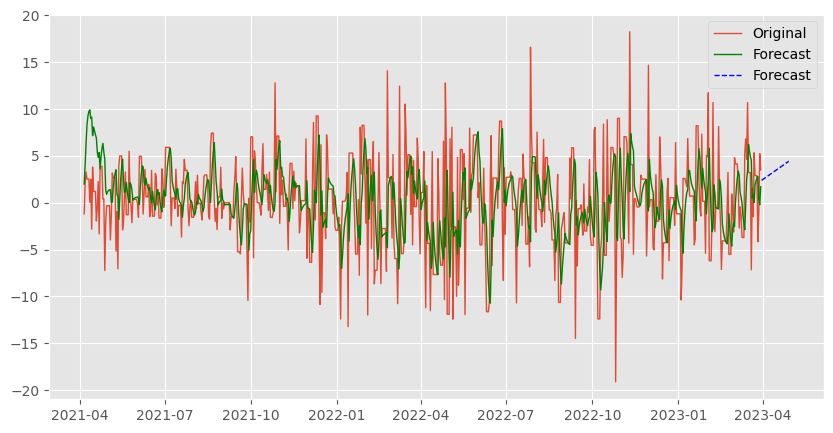

In [128]:
from statsmodels.tsa.api import Holt
df=df.asfreq('D')
# Fit the model with automatic optimization
model = Holt(df['Diff'].dropna()).fit(optimized=True)
# Print the coefficients
print(model.params)
# Print the fitted model summary
print(model.summary())

# Forecast the next 24 periods
forecast = model.forecast(steps=30)
# Plot the original data, the exponential smoothing, and the forecast
plt.figure(figsize=(10, 5))
plt.plot(df['Diff'], label='Original', linewidth=1)
plt.plot(model.fittedvalues, label='Forecast', color='green', linewidth=1)
plt.plot(forecast, label='Forecast', color='blue', linewidth=1, linestyle='--')
plt.legend(loc='best')
plt.show()

/Users/govindbhat/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


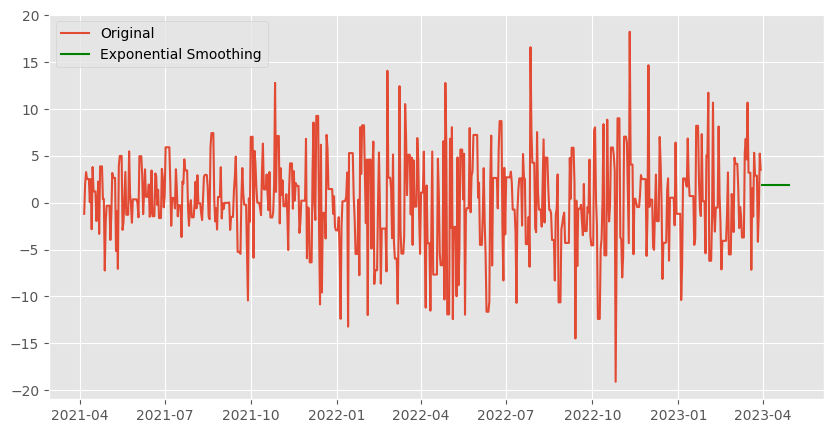

In [199]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Fit the model
model = SimpleExpSmoothing(df['Diff'].dropna()).fit(smoothing_level=0.2)

# Create a new date range for the forecast
future_dates = [df.index[-1] + DateOffset(days=x) for x in range(1, 101)]

# Forecast the next 100 periods
forecast = pd.Series(model.forecast(30), index=future_dates)

# Plot the original data and the exponential smoothing
plt.figure(figsize=(10, 5))
plt.plot(df['Diff'], label='Original')
plt.plot(forecast, label='Exponential Smoothing', color='green')
plt.legend(loc='best')

In [134]:
# Split the data into training and validation sets
train = df['Diff'].dropna()[:-30]
valid = df['Diff'].dropna()[-31:]
train.asfreq('B')
# Fit the model on the training set
model = Holt(train).fit(optimized=True)

# Forecast the validation set
forecast = model.forecast(30)

# Calculate the error metrics
mae = mean_absolute_error(valid, forecast)
mse = mean_squared_error(valid, forecast)
rmse = sqrt(mse)

print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

ValueError: Found input variables with inconsistent numbers of samples: [31, 32]

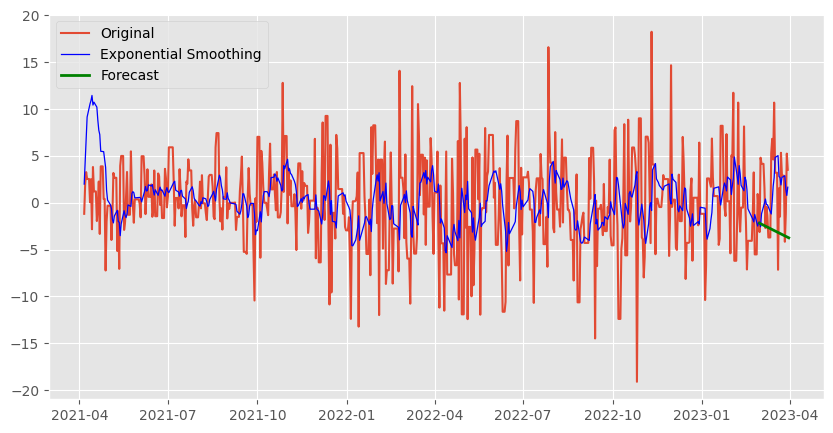

In [133]:


# Plot the original data, the exponential smoothing, and the forecast
plt.figure(figsize=(10, 5))
plt.plot(df['Diff'], label='Original')
plt.plot(validation, label='Exponential Smoothing', color='blue', linewidth=0.9)
plt.plot(forecast, label='Forecast', color='green', linewidth=2)
plt.legend(loc='best')
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   Diff   No. Observations:                  724
Model:                 ARIMA(1, 0, 4)   Log Likelihood               -2136.366
Date:                Fri, 29 Dec 2023   AIC                           4286.731
Time:                        06:26:22   BIC                           4318.825
Sample:                    04-06-2021   HQIC                          4299.118
                         - 03-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1428      0.239      0.597      0.551      -0.326       0.612
ar.L1          0.3703      0.721      0.514      0.608      -1.043       1.783
ma.L1         -0.0834      0.720     -0.116      0.9

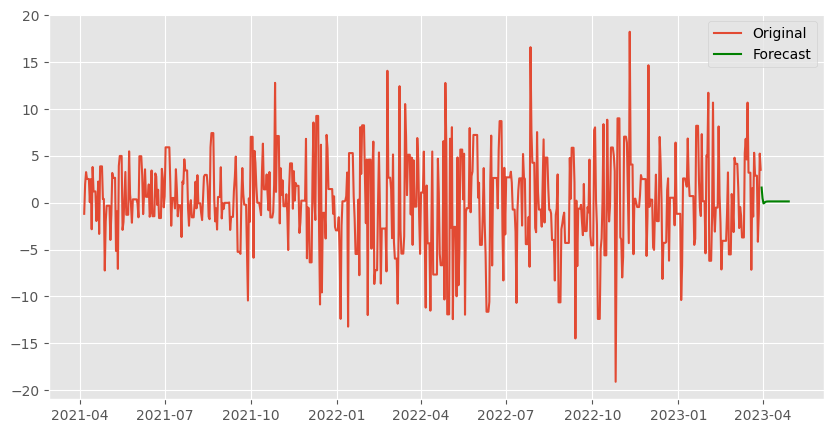

In [187]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model
# The order (p,d,q) needs to be determined using model diagnostics and AIC/BIC criteria
model = ARIMA(df['Diff'].dropna(), order=(1,0,4))
results = model.fit()

# Summary of the model
print(results.summary())

# Forecasting future values
forecast = results.forecast(steps=30)

# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(df['Diff'], label='Original')
plt.plot(forecast, label='Forecast', color='green')
plt.style.use('ggplot')
plt.legend(loc='best')
plt.show()

In [188]:
# Assuming 'actuals' is a pandas Series of actual values and 'predictions' is of forecasted values
actuals = df['Diff'].ffill()[-30:].values
predictions = forecast

# Calculate MAE
mae = mean_absolute_error(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate RMSE
rmse = mean_squared_error(actuals, predictions, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate SMAPE
smape = 100/len(actuals) * np.sum(2 * np.abs(predictions - actuals) / (np.abs(actuals) + np.abs(predictions)))
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%')

# Calculate MAPE
mape = 100/len(actuals) * np.sum(np.abs((actuals - predictions) / actuals))
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Error (MAE): 3.7792471650520665
Root Mean Squared Error (RMSE): 4.26731919041752
Symmetric Mean Absolute Percentage Error (SMAPE): 190.45%
Mean Absolute Percentage Error (MAPE): 102.13%


In [ ]:
from fbprophet import Prophet

# Prepare the data
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize the model
model = Prophet()

# Fit the model
model.fit(df)

# Make a future dataframe for prediction
future = model.make_future_dataframe(periods=365)

# Use the model to make predictions
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)